<div style="background-color:#D2DCFA; padding:10px;">
    
# Описание задачи
    
Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:
    
В избранном регионе собирают характеристики для скважин: 
    
   > качество нефти и объём её запасов;
    
   > строят модель для предсказания объёма запасов в новых скважинах;
    
   > выбирают скважины с самыми высокими оценками значений;
    
   > определяют регион с максимальной суммарной прибылью отобранных скважин.

---
    
# Условия задачи
    
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);
    
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
    
    
Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. **Построим модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.**

<div style="background-color:#D2DCFA; padding:10px;">
    
# Описание данных
    
Нам предоставлены данные о трёх регионах - три датасета с идентичными столбцами:
    
- **`id`** — уникальный идентификатор скважины;
    
- **`f0`**, **`f1`**, **`f2`** — три признака точек;
- **`product`** — объём запасов в скважине (тыс. баррелей).

In [1]:
!pip install -U scikit-learn

In [2]:
import pandas as pd 
import numpy as np 
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from phik import phik_matrix
from phik.report import plot_correlation_matrix


sns.set_style('darkgrid')

In [3]:
RANDOM_STATE = 123
TEST_SIZE = 0.25

## Шаг 1. Подготовка данных

In [4]:
# Загрузим данные
try:
    reg_1 = pd.read_csv(r"C:\Users\ilyal\OneDrive\Рабочий стол\Портфолио\practicum_projects\black_gold_holes_9\geo_data_0.csv")
    reg_2 = pd.read_csv(r"C:\Users\ilyal\OneDrive\Рабочий стол\Портфолио\practicum_projects\black_gold_holes_9\geo_data_1.csv")
    reg_3 = pd.read_csv(r"C:\Users\ilyal\OneDrive\Рабочий стол\Портфолио\practicum_projects\black_gold_holes_9\geo_data_2.csv")  
except:
    reg_1 = pd.read_csv(r'/datasets/geo_data_0.csv')
    reg_2 = pd.read_csv(r'/datasets/geo_data_1.csv')
    reg_3 = pd.read_csv(r'/datasets/geo_data_2.csv')
    
reg_1.sample(10)

,id,f0,f1,f2,product
20496,jYNhR,-1.092834,0.144644,3.115041,103.901153
45365,kFYaD,-0.741609,0.484095,5.342645,132.251618
8417,YlsCd,1.847784,0.158976,-3.839811,102.789353
12746,P5h8l,0.009799,0.884679,7.843341,135.010095
94982,3sTHo,0.418049,0.722597,4.540834,161.263883
7720,YXtMU,0.020917,0.185670,0.380153,38.020561
58594,adOVw,-0.392431,0.978137,7.662090,98.113973
71691,fqFDE,-1.064999,0.412555,0.146674,85.537406
19437,578Mm,2.028612,0.473561,1.827272,160.597231
47991,e1pG4,0.635628,0.809962,3.001824,29.347698


На первый взгляд проблем с данными нет. Посмотрим на них ближе.

Выведем информацию о всех регионах для проверки типов данных столбцов и наличие пропусков.

In [5]:
regs = [reg_1, reg_2, reg_3]

for i, reg in enumerate(regs, 1):
    print(f'Регион {i}')
    display(reg.info())

Регион 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Регион 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Регион 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков в данных нет, все типы данных правильные.

### Изучим данные

Построим для числовых столбцов все необходимые графики.

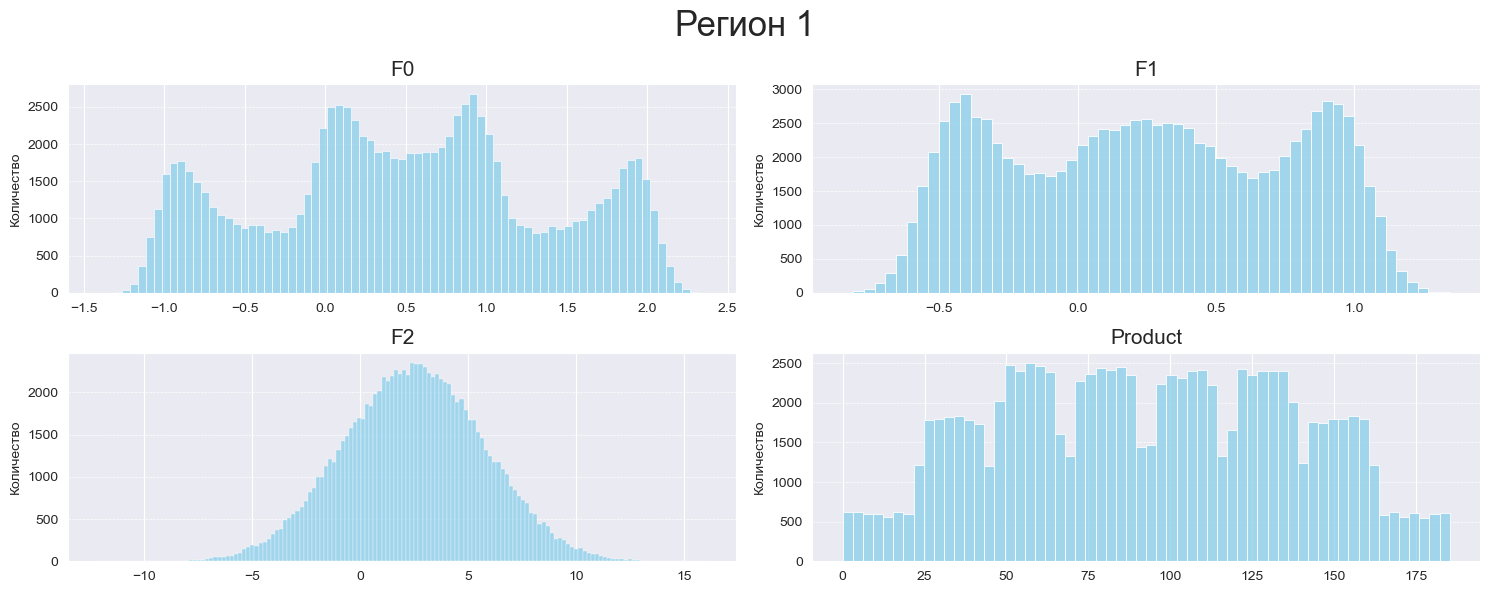

In [6]:
hist_cols = ['f0', 'f1', 'f2', 'product']

plt.figure(figsize=(15, 6))
for i, col in enumerate(hist_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=reg_1, x=col, color='skyblue')
    plt.suptitle('Регион 1', fontsize=25)
    plt.title(col.capitalize(), fontsize=15)
    plt.xlabel('')
    plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    
plt.tight_layout()
plt.show()

**Вывод:**

- признаки `f0`, `f1` и `product` имеют мультимодальное распределение. В последнем столбце количество пиков равно 5;

- признак `f2` имеет нормальное распределение.

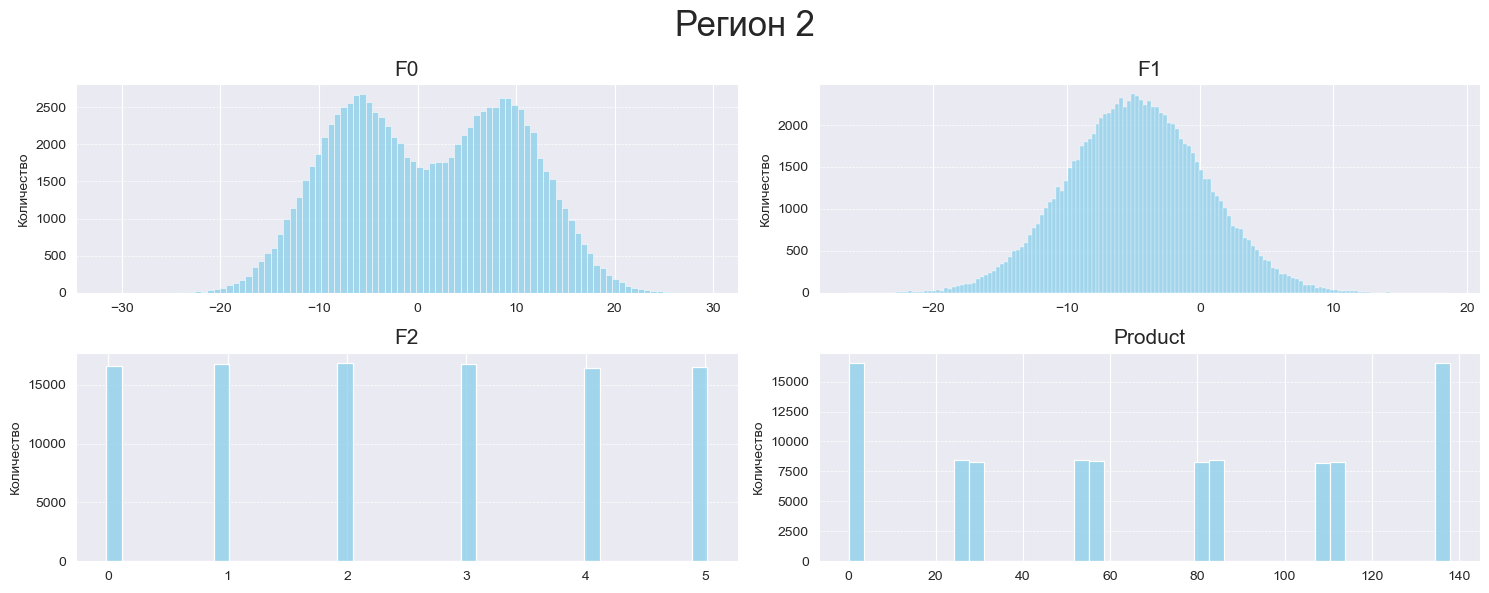

In [7]:
plt.figure(figsize=(15, 6))
for i, col in enumerate(hist_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=reg_2, x=col, color='skyblue')
    plt.suptitle('Регион 2', fontsize=25)
    plt.title(col.capitalize(), fontsize=15)
    plt.xlabel('')
    plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    
plt.tight_layout()
plt.show()

**Вывод:**

- признак `f0` имеет бимодальное распределение;
- признак `f1` имеет нормальное распределение;
- значения признаков `f2` и `product` разбиты на группы. 

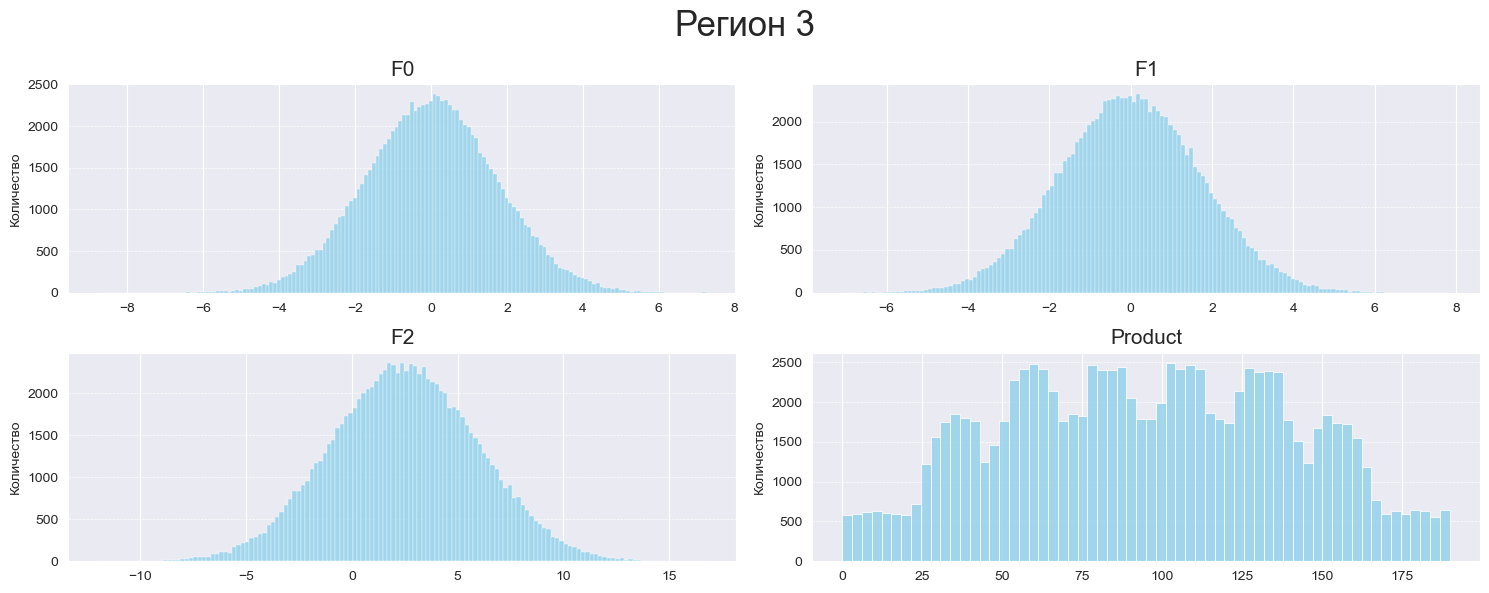

In [8]:
plt.figure(figsize=(15, 6))
for i, col in enumerate(hist_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=reg_3, x=col, color='skyblue')
    plt.suptitle('Регион 3', fontsize=25)
    plt.title(col.capitalize(), fontsize=15)
    plt.xlabel('') 
    plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    
plt.tight_layout()
plt.show()

**Вывод:**

- признаки `f0`, `f1` и `f2` имеют нормальное распределение;

- признак `product` имеет мультимодальное распределение с 4-мя явными пиками.

Проведем корреляционный анализ всех датафреймов.

In [9]:
interval_cols = ['f0', 'f1', 'f2', 'product']

t = reg_1.drop('id', axis=1)

phik_overview = phik_matrix(t, interval_cols=interval_cols)

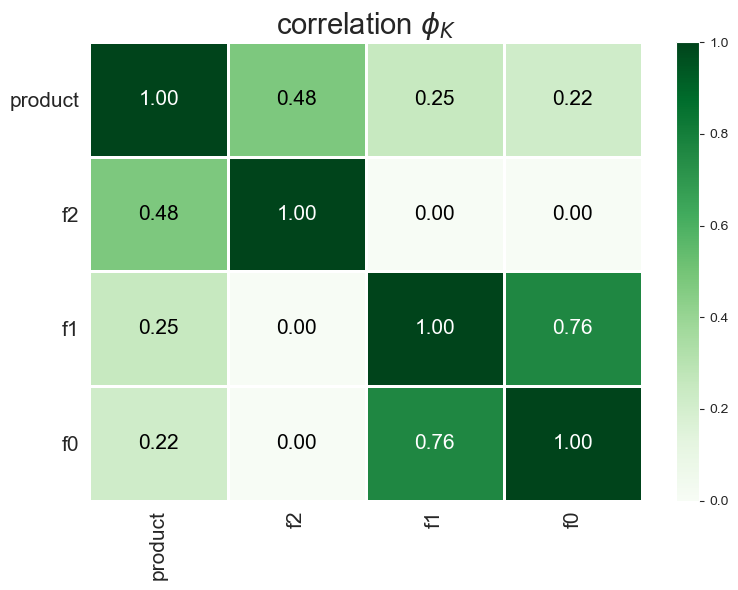

In [10]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(8, 6)
) 

**Вывод:**

- наибольшая корреляция с целевым у признака `f2`
- остальные признаки вляния не целевой практически не имеют

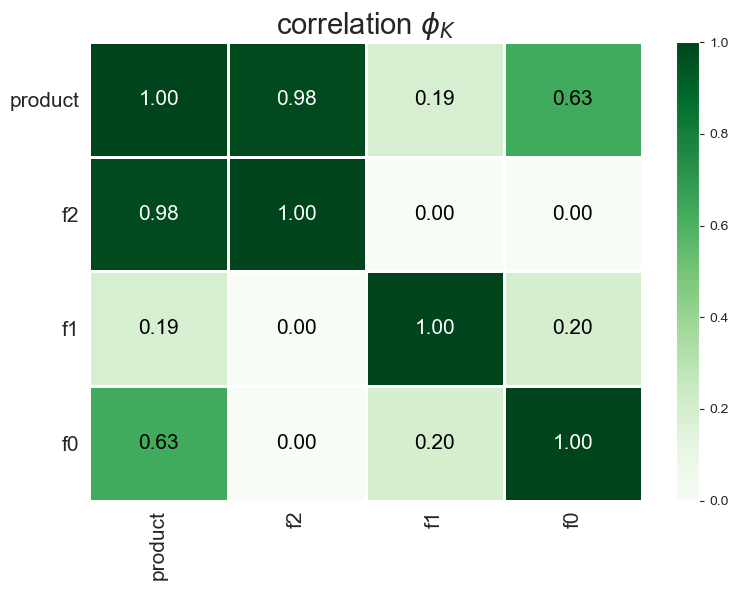

In [11]:
t = reg_2.drop('id', axis=1)

phik_overview = phik_matrix(t, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(8, 6)
) 

**Вывод:**

- наибольшая корреляция с целевым у признака `f2`, коэфициент **0.98**

- так же достаточно сильно влияет признак `f0`, коэфициент **0.63** 

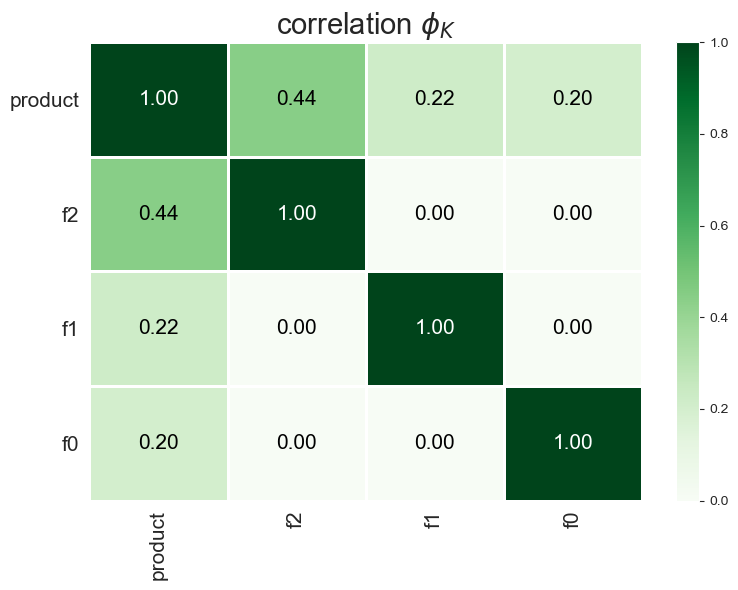

In [12]:
t = reg_3.drop('id', axis=1)

phik_overview = phik_matrix(t, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(8, 6)
) 

**Вывод:**

- так же как и в предыдущих случаях самая выраженная корреляция между признаком `f2`

<div style="background-color:#D2DCFA; padding:10px;">

## Промежуточный вывод
    
- Была проведена загрузка и проверка целостности и правильности данных. Все типы данных имеют правильный формат, пропусков в данных нет.
    
- Был проведен небольшой исследовательский анализ данных. Построены гистограммы для всех числовых столбцов.
    
- Был проведен корреляционный анализ. Выявлена четкая зависимость между количеством запасов нефти и признаком `f2` во всех датафреймах

---

## Шаг 2. Построение моделей.

### 2.1. Модель для первого региона.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(reg_1.drop(['id', 'product'], axis=1),
                                                      reg_1['product'],
                                                      test_size=TEST_SIZE,
                                                      random_state=RANDOM_STATE)

X_train.shape, X_valid.shape

((75000, 3), (25000, 3))

In [14]:
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train)
X_valid_scaled_1 = scaler.transform(X_valid)

model_1 = LinearRegression()
model_1.fit(X_train_scaled_1, y_train)

predict_1 = model_1.predict(X_valid_scaled_1)

valid_results_1 = pd.DataFrame({'predictions': predict_1, 'actual': y_valid})

mean_predicted_product_1 = valid_results_1['predictions'].mean()
RMSE_1 = np.sqrt(mean_squared_error(y_valid, predict_1))
print("Средний запас предсказанного сырья:", mean_predicted_product_1)
print("RMSE модели:", RMSE_1)

Средний запас предсказанного сырья: 92.54936189116309
RMSE модели: 37.64786282376177


---

### 2.2. Модель для второго региона.

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(reg_2.drop(['id', 'product'], axis=1),
                                                      reg_2['product'],
                                                      test_size=TEST_SIZE,
                                                      random_state=RANDOM_STATE)

X_train.shape, X_valid.shape

((75000, 3), (25000, 3))

In [16]:
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train)
X_valid_scaled_2 = scaler.transform(X_valid)

model_2 = LinearRegression()
model_2.fit(X_train_scaled_2, y_train)

predict_2 = model_2.predict(X_valid_scaled_2)

valid_results_2 = pd.DataFrame({'predictions': predict_2, 'actual': y_valid})

mean_predicted_product_2 = valid_results_2['predictions'].mean()
RMSE_2 = np.sqrt(mean_squared_error(y_valid, predict_2))
print("Средний запас предсказанного сырья:", mean_predicted_product_2)
print("RMSE модели:", RMSE_2)

Средний запас предсказанного сырья: 69.28001860653976
RMSE модели: 0.8954139804944308


---

### 2.3. Модель для третьего региона.

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(reg_3.drop(['id', 'product'], axis=1),
                                                      reg_3['product'],
                                                      test_size=TEST_SIZE,
                                                      random_state=RANDOM_STATE)

X_train.shape, X_valid.shape

((75000, 3), (25000, 3))

In [18]:
scaler = StandardScaler()
X_train_scaled_3 = scaler.fit_transform(X_train)
X_valid_scaled_3 = scaler.transform(X_valid)

model_3 = LinearRegression()
model_3.fit(X_train_scaled_3, y_train)

predict_3 = model_3.predict(X_valid_scaled_3)

valid_results_3 = pd.DataFrame({'predictions': predict_3, 'actual': y_valid})

mean_predicted_product_3 = valid_results_3['predictions'].mean()
RMSE_3 = np.sqrt(mean_squared_error(y_valid, predict_3))
print("Средний запас предсказанного сырья:", mean_predicted_product_3)
print("RMSE модели:", RMSE_3)

Средний запас предсказанного сырья: 95.09859933591373
RMSE модели: 40.12803006598514


---

### 2.4. Анализ результатов.

Выведем на экран средний запас предсказанного сырья каждого региона и RMSE моделей

In [19]:
print('Регион 1:')
print(f'Средний запас предсказанного сырья: {mean_predicted_product_1}')
print(f'Средний запас фактического сырья: {valid_results_1.actual.mean()}')
print(f'RMSE модели: {RMSE_1}')
print('')
print('Регион 2:')
print(f'Средний запас предсказанного сырья: {mean_predicted_product_2}')
print(f'Средний запас фактического сырья: {valid_results_2.actual.mean()}')
print(f'RMSE модели: {RMSE_2}')
print('')
print('Регион 3:')
print(f'Средний запас предсказанного сырья: {mean_predicted_product_3}')
print(f'Средний запас фактического сырья: {valid_results_3.actual.mean()}')
print(f'RMSE модели: {RMSE_3}') 

Регион 1:
Средний запас предсказанного сырья: 92.54936189116309
Средний запас фактического сырья: 92.85062391123445
RMSE модели: 37.64786282376177

Регион 2:
Средний запас предсказанного сырья: 69.28001860653976
Средний запас фактического сырья: 69.27371236077902
RMSE модели: 0.8954139804944308

Регион 3:
Средний запас предсказанного сырья: 95.09859933591373
Средний запас фактического сырья: 94.87348818660213
RMSE модели: 40.12803006598514


<div style="background-color:#D2DCFA; padding:10px;">

## Промежуточный вывод
    
- Были построены модели для каждого региона.
    
- Была подсчитана метрика RMSE.
    
- Лучшая метрика оказалась у модели №2, что неудивительно, так как корреляция между признаком `f2` и целевым практически равна единице.

---

## Шаг 3. Подготовка к расчету прибыли.

In [20]:
BUDGET = 10 ** 10
PRICE = 450_000
COUNT = 200

actual_1 = valid_results_1['actual']
actual_2 = valid_results_2['actual']
actual_3 = valid_results_3['actual']

pred_1 = valid_results_1['predictions']
pred_2 = valid_results_2['predictions']
pred_3 = valid_results_3['predictions']

Так как для разработки выбираются 200 скважин из 500, нам необходимо узнать обьем для безубыточной работы именно  в них.

Разделим бюджет на разработку на количество скважин, тем самым узнаем сколько должна приносить каждая.

In [21]:
profit_hole = BUDGET / COUNT
print(f'Для безубыточной работы каждая скважина должна приносить не менее {profit_hole} руб.')

Для безубыточной работы каждая скважина должна приносить не менее 50000000.0 руб.


Получается, что каждая скважина должна приносить не менее 50 млн.руб.

In [22]:
min_reserve = profit_hole / PRICE
print(f'Минимальный запас каждой скважины должен быть {round(min_reserve, 2)} тыс.баррелей')

Минимальный запас каждой скважины должен быть 111.11 тыс.баррелей


Сравним минимальный запас каждой скважины с средним запасом по региону.

In [23]:
print('Средний запас скважин для региона №1:', round(reg_1['product'].mean(), 2))
print('Средний запас скважин для региона №2:', round(reg_2['product'].mean(), 2))
print('Средний запас скважин для региона №3:', round(reg_3['product'].mean(), 2))

Средний запас скважин для региона №1: 92.5
Средний запас скважин для региона №2: 68.83
Средний запас скважин для региона №3: 95.0


Как видно, среднее значение запасов в каждом регионе меньше минимального для безубыточной разработки. Из чего следует, что нельзя выбирать скважину рандомным образом, а использовать модель для прогнозирования наиболее прибыльных скважин.

<div style="background-color:#D2DCFA; padding:10px;">

## Промежуточный вывод
    
Цена на разработку одной скважины составляет 50 млн.руб., из чего следует, что каждая скважина должна приносить не менее 111 тыс.баррелей нефти.
    
Средний запас скважин для всех регионов ниже минимального для безубыточной разработки. Нужно тщательно выбирать самые прибыльные скважины с помощью модели.

---

## Шаг 4. Функция для расчета прибыли.

Напишем функцию для расчета прибыли. На вход она принимает реальные и предсказанные значения валидационной выборки, а так же число скважин для разработки.

In [24]:
def profit(true_values, predicted_values, count):
    predicted_values_sorted = predicted_values.sort_values(ascending=False)
    selected = true_values[predicted_values_sorted.index][:count]
    top_200_sum = selected.sum()
    
    total_profit = top_200_sum * PRICE - BUDGET
    
    return total_profit

## Шаг 5. Подсчет прибыли и рисков.

Напишем функцию для бутстрепа на 1000 итераций, которая на вход принимает реальные и предсказанные значения на валидационной выборки. Затем рассчитаем среднюю прибыль для региона и риск убытков в процентах.

In [25]:
STATE = RandomState(12345)

def bootstrap_proklyatiy(actual, pred):
    values = []
    for i in range(1000):
        target_subsample = actual.sample(n=500, replace=True, random_state=STATE)
        probs_subsample = pred[target_subsample.index]
        profit_value = profit(target_subsample, probs_subsample, COUNT)
        values.append(profit_value)
        
    values = pd.Series(values)
    values_mean = values.mean() 
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    loss_risk = np.mean(values < 0)
    
    print(f'Средняя прибыль в регионе: {round(values_mean/1_000_000, 2)} млн.руб.')
    print(f'95%-й доверительный интервал в регионе: от {round(lower/1_000_000, 2)} до {round(upper/1_000_000, 2)} млн.руб.')
    print(f'Риск убытков в регионе: {loss_risk * 100}%') 

# Регион №1

In [26]:
bootstrap_proklyatiy(actual_1, pred_1)

Средняя прибыль в регионе: 505.26 млн.руб.
95%-й доверительный интервал в регионе: от -1.09 до 1062.11 млн.руб.
Риск убытков в регионе: 2.6%


# Регион №2

In [27]:
bootstrap_proklyatiy(actual_2, pred_2)

Средняя прибыль в регионе: 534.11 млн.руб.
95%-й доверительный интервал в регионе: от 113.67 до 960.06 млн.руб.
Риск убытков в регионе: 0.2%


# Регион №3

In [28]:
bootstrap_proklyatiy(actual_3, pred_3)

Средняя прибыль в регионе: 370.65 млн.руб.
95%-й доверительный интервал в регионе: от -189.18 до 900.76 млн.руб.
Риск убытков в регионе: 10.0%


<div style="background-color:#D2DCFA; padding:10px;">

## Промежуточный вывод
    
- Была проведена процедура бутстрапа для 1000 выборок. У региона №2 вероятность убытков составила 0.2%, что соответствует условию задачи.

---

<div style="background-color:#D2DCFA; padding:10px;">

# Финальный вывод.
    
- Была проведена загрузка и проверка целостности и правильности данных. Все типы данных имеют правильный формат, пропусков в данных нет.
    
- Был проведен небольшой исследовательский анализ данных. Построены гистограммы для всех числовых столбцов.
    
- Был проведен корреляционный анализ. Выявлена четкая зависимость между количеством запасов нефти и признаком `f2` во всех датафреймах
    
- Были построены модели для каждого региона.
    
- Была подсчитана метрика RMSE.
    
- Лучшая метрика оказалась у модели №2, что неудивительно, так как корреляция между признаком `f2` и целевым практически равна единице.
    
- Цена на разработку одной скважины составляет 50 млн.руб., из чего следует, что каждая скважина должна приносить не менее 111 тыс.баррелей нефти.
    
- Средний запас скважин для всех регионов ниже минимального для безубыточной разработки. Нужно тщательно выбирать самые прибыльные скважины с помощью модели.
    
- Была написана функция для расчета прибыли
    
- Была проведена процедура бутстрапа для 1000 выборок. У региона №2 вероятность убытков составила 1%, что соответствует условию задачи.
    
---
    
Данные для каждого региона:
    
1. Регион №1:
    - Средний запас предсказанного сырья: 92.54936189116309
    - Средний запас фактического сырья: 92.85062391123445
    - RMSE модели: 37.64786282376177
    - Средняя прибыль в регионе: 505.26 млн.руб.
    - 95%-й доверительный интервал в регионе: от -1.09 до 1062.11 млн.руб.
    - Риск убытков в регионе: 2.6%
    
2. Регион №2:
    - Средний запас предсказанного сырья: 69.28001860653976
    - Средний запас фактического сырья: 69.27371236077902
    - RMSE модели: 0.8954139804944308
    - Средняя прибыль в регионе: 534.11 млн.руб.
    - 95%-й доверительный интервал в регионе: от 113.67 до 960.06 млн.руб.
    - Риск убытков в регионе: 0.2%
    
3. Регион №3:
    - Средний запас предсказанного сырья: 95.09859933591373
    - Средний запас фактического сырья: 94.87348818660213
    - RMSE модели: 40.12803006598514
    - Средняя прибыль в регионе: 370.65 млн.руб.
    - 95%-й доверительный интервал в регионе: от -189.18 до 900.76 млн.руб.
    - Риск убытков в регионе: 10.0%
    
---
    
В итоге лучшим регионом для безубыточной разработки скважин оказался регион №2. В нем достаточно высокая средняя прибыль, а риск убытков составляет `0.2%`. Для разработки я бы рекомендовал второй регион, так бизнес хорошо заработает с минимальными рисками.